In [1]:
# !pip install datasets
# !pip install matplotlib

In [2]:
import utilities as utils
import pandas as pd
import numpy as np
from collections import Counter
from datasets import load_dataset

## Loading the data

For the sake of the example, assume our entire corpus is just the training data from the NER Hin-Eng dataset in LinCE:

In [3]:
corpus = {
    'original': load_dataset('lince', 'ner_hineng', split="train")
}

print(corpus)

Reusing dataset lince (/Users/gustalas/.cache/huggingface/datasets/lince/ner_hineng/1.0.0/e0897cf2baf87d06bc1279bd0498eb68535dd36726ba2d5333661cb476986036)


{'original': Dataset({
    features: ['idx', 'words', 'lid', 'ner'],
    num_rows: 1243
})}


This training data has a good CMI (it matches with Table 3 in the paper):

In [4]:
# cmi_stats = utils.get_corpus_cmi(corpus, langs={'eng', 'eng&spa', 'spa'})
# cmi_stats = utils.get_corpus_cmi(corpus, langs={'lang1', 'la ng2', 'mixed', 'fw'})
cmi_stats = utils.get_corpus_cmi(corpus, langs={'en', 'hi'})
cmi_stats

{'original': {'cmi_all': 20.117,
  'cmi_cm': 25.412,
  'all_sents': 1243.0,
  'all_tokens': 21065,
  'cm_sents': 984.0}}

## Inspecting the original corpus

Recall that corpus is assumed to be our entire data (train + dev + test). We need to inspect the distribution of different aspects in the entire corpus to make sure they replicate in the stratified splits:

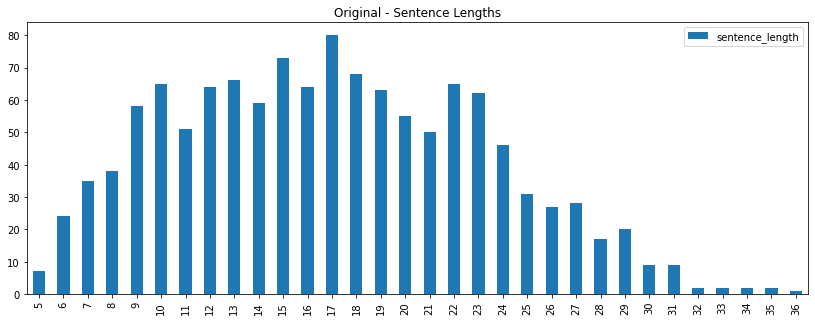

In [5]:
def plot_sentence_lengths(corpus):
    for split in corpus:
        counts = Counter([len(sample) for sample in corpus[split]['words']])
        counts_df = pd.DataFrame({'sentence_length': counts})
        counts_df.plot.bar(title=split.title() + ' - Sentence Lengths', figsize=(14,5))
        
plot_sentence_lengths(corpus)

In [6]:
def split_counters(datasplit, field):
    return Counter(utils.flatten(datasplit[field]))
    
def corpus_counters(corpus, field):
    counters = {}
    for dataset in corpus:
        counters[dataset] = split_counters(corpus[dataset], field)
    return counters

In [7]:
pd.DataFrame(corpus_counters(corpus, field='lid'))

,original
en,8198
hi,6905
rest,5962


<AxesSubplot:>

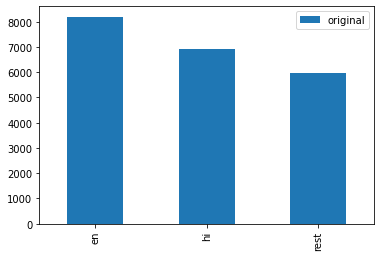

In [8]:
pd.DataFrame(corpus_counters(corpus, field='lid')).plot.bar()

<AxesSubplot:>

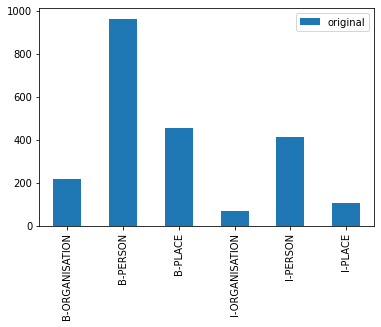

In [9]:
pd.DataFrame(corpus_counters(corpus, field='ner'))[:-1].plot.bar() # [:-1] to ignore the O label for the plot

In [10]:
print('Sentences: {:,}'.format(len(corpus['original']['words'])))
print('   Tokens: {:,}'.format(len(utils.flatten(corpus['original']['words']))))

Sentences: 1,243
   Tokens: 21,065


## Stratification

The stratification needs to consider:

* a similar distribution of entity labels
* a similar distribution of langid labels
* a similar distribution of sentence lengths
* the least number of overlapping entity instances between train and dev/test
* a ratio of 70:10:20 (47,056 : 6,722 : 13,445)

In [11]:
def unify_labels_for_stratification(unified_corpus, extra_labels=[], snd_label_type='ner'):
    unified_labels = Counter()
    unified_labels.update(split_counters(unified_corpus, field='lid'))
    unified_labels.update(split_counters(unified_corpus, field=snd_label_type))
    unified_labels = {label: i for i, label in enumerate(sorted(unified_labels.keys()) + extra_labels)}
    return unified_labels

def length_to_category(length):
    if length <= 5:
        return 'small'
    elif 5 < length <= 10: 
        return 'medium'
    else: 
        return 'large'
    
def uniq_labels_per_sample(dataset, label_mapper, snd_label_type='ner'):
    unified = [] 
    for i in range(len(dataset['words'])):
        lid_encoding = [label_mapper[lid] for lid in dataset['lid'][i]]
        snd_encoding = [label_mapper[snd] for snd in dataset[snd_label_type][i]]
        len_encoding = [label_mapper[length_to_category(len(dataset['words'][i]))]]
        unified.append(sorted(set(lid_encoding + snd_encoding + len_encoding)))
    return unified

def stratify_train_test(full_dataset, label2index, eval_ratio):
    train_dataset = {'words': [], 'lid': [], 'ner': []}
    test_dataset = {'words': [], 'lid': [], 'ner': []}
    
    label_data = uniq_labels_per_sample(full_dataset, label2index)
    label_uniq = sorted(label2index.values())
    
    train_ratio = 1 - eval_ratio
    split_indexes, split_labels = utils.stratify(label_data, label_uniq, [train_ratio, eval_ratio])
    
    for split_i, dataset in enumerate([train_dataset, test_dataset]):
        for sample_index in split_indexes[split_i]:
            dataset['words'].append(full_dataset['words'][sample_index])
            dataset['lid'].append(full_dataset['lid'][sample_index])
            dataset['ner'].append(full_dataset['ner'][sample_index])
    
    return train_dataset, test_dataset

def stratify_corpus(full_dataset, label2index, ratio):
    temp_ratio = sum(ratio[1:])  # the sum of ratios for dev and test
    train_dataset, temp_dataset = stratify_train_test(full_dataset, label2index, temp_ratio)
    
    test_ratio = ratio[2] / temp_ratio # test ratio divided by the sum of dev and test ratio
    dev_dataset, test_dataset = stratify_train_test(temp_dataset, label2index, test_ratio)
    
    corpus = {
        'train': train_dataset,
        'dev': dev_dataset,
        'test': test_dataset
    }
    return corpus

Merge all the existing label types in our corpus (lid, ner, and sentence length categories):

In [12]:
label2index = unify_labels_for_stratification(corpus['original'], extra_labels=['small', 'medium', 'large'])
index2label = {index: label for label, index in label2index.items()}
index2label

{0: 'B-ORGANISATION',
 1: 'B-PERSON',
 2: 'B-PLACE',
 3: 'I-ORGANISATION',
 4: 'I-PERSON',
 5: 'I-PLACE',
 6: 'O',
 7: 'en',
 8: 'hi',
 9: 'rest',
 10: 'small',
 11: 'medium',
 12: 'large'}

Let's run the stratification now that we have everything ready (this may take a few minutes for large datasets):

In [13]:
new_corpus = stratify_corpus(corpus['original'], label2index, ratio=[0.5, 0.15, 0.35])

## Inspecting the resulting stratified data

In [14]:
print("Train: {:,}".format(len(new_corpus['train']['words'])))
print("  Dev: {:,}".format(len(new_corpus['dev']['words'])))
print(" Test: {:,}".format(len(new_corpus['test']['words'])))

Train: 621
  Dev: 187
 Test: 435


      original  train   dev  test
en        8198   4153  1197  2848
hi        6905   3485  1015  2405
rest      5962   2955   934  2073
AxesSubplot(0.125,0.125;0.775x0.755)


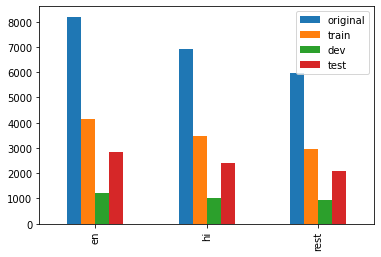

In [15]:
new_lid_df = pd.DataFrame({
    'original': split_counters(corpus['original'], field='lid'),
    'train':    split_counters(new_corpus['train'], field='lid'),
    'dev':      split_counters(new_corpus['dev'], field='lid'),
    'test':     split_counters(new_corpus['test'], field='lid'),
})
print(new_lid_df)
print(new_lid_df.plot.bar())

                original  train   dev  test
O                  18843   9500  2809  6534
B-PERSON             963    475   146   342
I-PERSON             411    201    66   144
B-PLACE              455    222    69   164
B-ORGANISATION       218    109    29    80
I-PLACE              108     52    17    39
I-ORGANISATION        67     34    10    23
AxesSubplot(0.125,0.125;0.775x0.755)


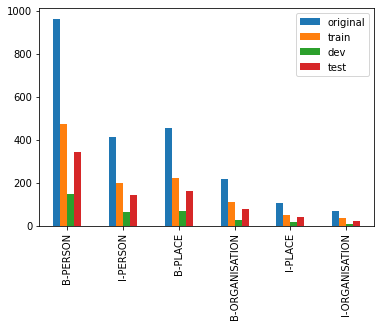

In [16]:
new_ner_df = pd.DataFrame({
    'original':  split_counters(corpus['original'], field='ner'),
    'train': split_counters(new_corpus['train'], field='ner'),
    'dev':   split_counters(new_corpus['dev'], field='ner'),
    'test':  split_counters(new_corpus['test'], field='ner'),
})
print(new_ner_df)
print(new_ner_df[1:].plot.bar())

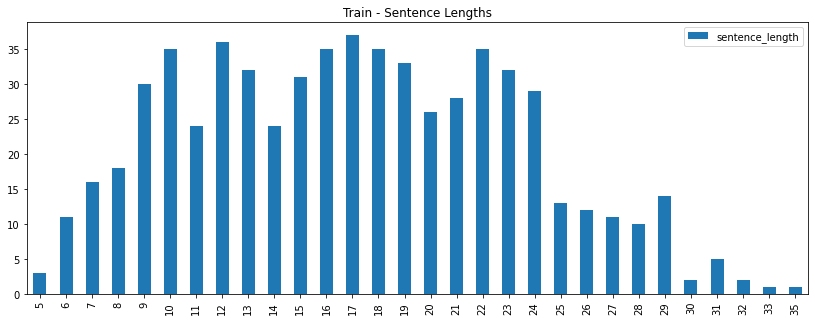

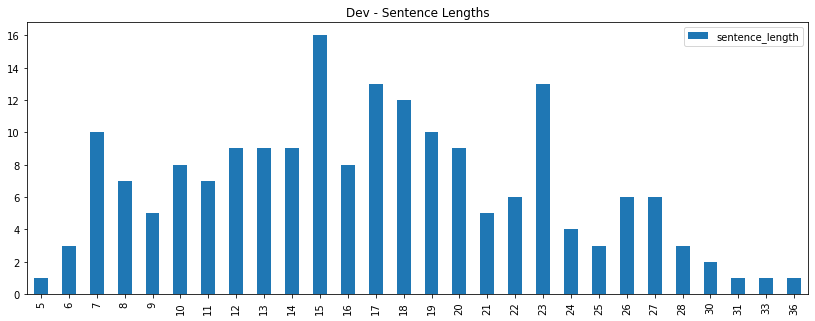

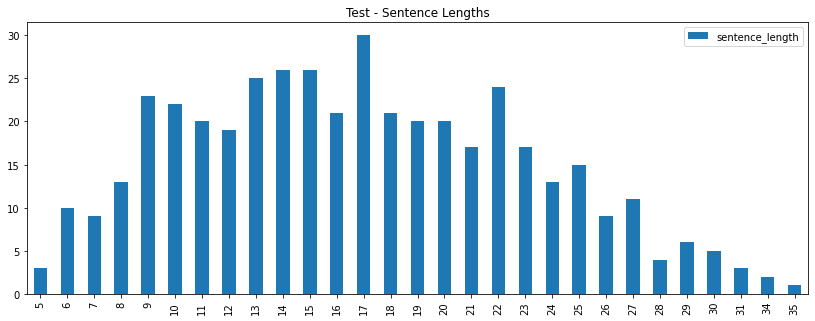

In [17]:
plot_sentence_lengths(new_corpus)

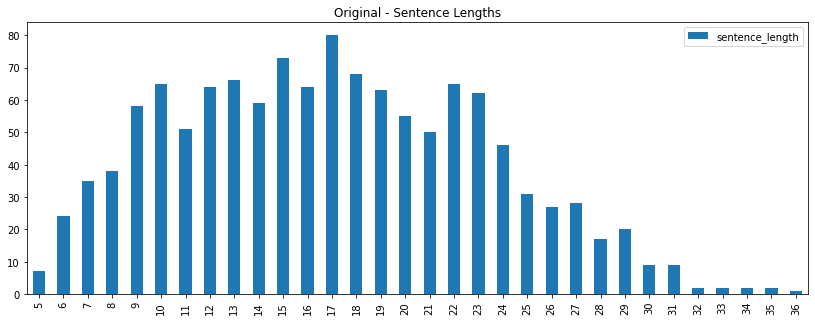

In [18]:
plot_sentence_lengths(corpus)

KL-divergence between new splits and whole corpus (expect small numbers, in the magnitude of x10^-4 or smaller):

In [19]:
def get_kl_div(p_dist, q_dist):
    p_np = []
    q_np = []
    
    for key in sorted(p_dist.keys()):
        if key not in q_dist:
            q_dist[key] = 1e-6
    
    p_sum = sum(p_dist.values())
    q_sum = sum(q_dist.values())
    
    for key in sorted(p_dist.keys()):    
        p_np.append(p_dist[key] / p_sum)
        q_np.append(q_dist[key] / q_sum)
        
    return utils.numpy_kl_div(np.array(p_np), np.array(q_np))


def print_kl_divergence(label_type='lid'):
    orig_dist = dict(Counter(utils.flatten(corpus['original'][label_type])))
    
    for split in new_corpus:
        split_dist = dict(Counter(utils.flatten(new_corpus[split][label_type])))
        kl_div = get_kl_div(orig_dist, split_dist) 
        print(split, kl_div)
        
print_kl_divergence('lid')

train 4.23042840016364e-05
dev 0.00046815491386697355
test 6.010825177379801e-07
